In [1]:
%run ../../_setup.py

from netCDF4 import Dataset
import xarray

from scipy.interpolate import griddata
import numpy as np

import pygmt

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cmo

import pandas as pd 



In [2]:
sys.path

['/home/janjaapmeijer/checkouts/phd/src/ss9802/02_analysis',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python37.zip',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/lib-dynload',
 '',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/htc_utils-0.1.0-py3.7.egg',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/nictools-1.1.5-py3.7.egg',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/webbpsf-0.9.0-py3.7.egg',
 '/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/IPython/extensions',
 '/home/janjaapmeijer/.ipython']

In [3]:
def gmtColormap(cptf, name=None):
    """Read a GMT color map from an OPEN cpt file
    Parameters
    ----------
    cptf : open file or url handle
        path to .cpt file
    name : str, optional
        name for color map
        if not provided, the file name will be used
    """
    # generate cmap name
    if name is None:
#         name = '_'.join(os.path.basename(cptf.name).split('.')[:-1])
        filename = os.path.basename(os.path.join(cptf))
        name = os.path.splitext(filename)[0]
    
    f = open(cptf)
    
    # process file
    x = []
    r = []
    g = []
    b = []
    lastls = None
    for l in f.readlines():
        ls = l.split()

        # skip empty lines
        if not ls:
            continue

        # parse header info
        if ls[0] in ["#", b"#"]:
            if ls[-1] in ["HSV", b"HSV"]:
                colorModel = "HSV"
            else:
                colorModel = "RGB"
            continue

        # skip BFN info
        if ls[0] in ["B", b"B", "F", b"F", "N", b"N"]:
            continue

        # parse color vectors
        x.append(float(ls[0]))
        r.append(float(ls[1]))
        g.append(float(ls[2]))
        b.append(float(ls[3]))

        # save last row
        lastls = ls

    x.append(float(lastls[4]))
    r.append(float(lastls[5]))
    g.append(float(lastls[6]))
    b.append(float(lastls[7]))
    
    x = np.array(x)
    r = np.array(r)
    g = np.array(g)
    b = np.array(b)

    if colorModel == "HSV":
        for i in range(r.shape[0]):
            # convert HSV to RGB
            rr,gg,bb = colorsys.hsv_to_rgb(r[i]/360., g[i], b[i])
            r[i] = rr ; g[i] = gg ; b[i] = bb
    elif colorModel == "RGB":
        r /= 255.
        g /= 255.
        b /= 255.

    red = []
    blue = []
    green = []
    xNorm = (x - x[0])/(x[-1] - x[0])
    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    # return colormap
    cdict = dict(red=red,green=green,blue=blue)
    return mcolors.LinearSegmentedColormap(name=name,segmentdata=cdict)

def export_cmap_to_cpt(cmap, vmin=0, vmax=1, N=255, filename="test.cpt",**kwargs):
    # create string for upper, lower colors
    b = np.array(kwargs.get("B", cmap(0.)))
    f = np.array(kwargs.get("F", cmap(1.)))
    na = np.array(kwargs.get("N", (0,0,0))).astype(float)
    ext = (np.c_[b[:3],f[:3],na[:3]].T * cmap.N).astype(int)
    extstr = "B {:3d} {:3d} {:3d}\nF {:3d} {:3d} {:3d}\nN {:3d} {:3d} {:3d}"
    ex = extstr.format(*list(ext.flatten()))
    #create colormap
    cols = (cmap(np.linspace(0.,1.,N))[:,:3]*cmap.N).astype(int)
    vals = np.linspace(vmin, vmax, N)
    arr = np.c_[vals[:-1],cols[:-1],vals[1:],cols[1:]]
    # save to file
    fmt = "%e %3d %3d %3d %e %3d %3d %3d"
    np.savetxt(filename, arr, fmt=fmt, 
               header="# COLOR_MODEL = RGB",
               footer = ex, comments="")


In [4]:
savefig = False

# Bathymetry (Smith and Sandwell, 1997)

In [5]:
input_file = os.path.join(datadir, 'external', 'bathymetry', 'gebco_2019', 'gebco_2019_n-45.0_s-60.0_w135.0_e160.0.nc')
bathy = xarray.open_dataset(input_file)

# boundaries
north = -52.4
west = 137
south = -48
east = 147

# dep = bathy.depth.sel(longitude=slice(west, east), latitude=slice(north, south))
dep = bathy.elevation.sel(lon=slice(west, east), lat=slice(north, south))
depths = np.linspace(-5000, 0, 11)


# Sea surface heights and derived variables
http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047


In [8]:
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')

# Select data over time of the voyage
ssh = xarray.open_dataset(input_file)
timevoy = slice('1998-03-12', '1998-03-28')
adtvoy = ssh.adt.sel(time=timevoy)

# Weekly mean ADT
weeks = np.unique(adtvoy.time.dt.week)
weekmeanadt = ssh.groupby('time.week').mean('time')['adt'][weeks-1]

adt_wkmean = ssh.sel(longitude=slice(west, east), latitude=slice(north, south)).adt.resample(time='7D').mean()

# # Sea Surface Temperature (SST)
# input_file_sst = os.path.join(datadir, 'external', 'sst', 'METOFFICE-GLO-SST-L4-REP-OBS-SST_1628835069513.nc')
# sst = xarray.open_dataset(input_file_sst)

# sst_wkmean = sst.sel(lon=slice(west, east), lat=slice(north, south)).analysed_sst.resample(time='7D').mean()


/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:383: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  FutureWarning,


# CTD stations SS9802 and SR3 stations AA9802

In [9]:
input_file = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd.nc')
ctd = Dataset(input_file)

input_file = os.path.join(datadir, 'au9706', 'processed', 'au9706_ctd.nc')
sr3 = Dataset(input_file)

In [10]:
stations = [2, 18, 19, 21, 23, 40, 41, 44, 46, 67, 66, 65, 53, 73]
istations = [i for i, station in enumerate(sr3['station'][:]) if station in stations]

# Orsi et al. 1995 fronts

In [11]:
orsi = {}
fronts = {'stf': 'tomato', 'saf': 'skyblue', 'pf': 'royalblue'}
for front in fronts.keys():
    input_file = os.path.join(datadir, 'external', 'orsi', front + '.txt')
    lon, lat = zip(*np.genfromtxt(input_file, delimiter='   ', comments='%'))
    orsi[front] = [lon, lat]


In [12]:
Nin = 256
Nout = 6
    
cmap = plt.get_cmap(cmo.cm.deep_r, cmo.cm.deep_r.N)
export_cmap_to_cpt(cmap, vmin=-5000, vmax=-1000, N=Nout, filename="../cmaps/cmocean_deep.cpt")

In [13]:
odds = [1, 2, 9, 10, 11, 12, 27, 45, 46, 47, 75, 76, 77, 78, 101]
iodds = [istat for istat, station in enumerate(ctd['station']) if station in odds]

In [14]:
ts = {1:2, 2:17, 3:18, 4:34, 5:36, 6:46, 7:64, 8:75, 9:76, 10:90, 11:93}

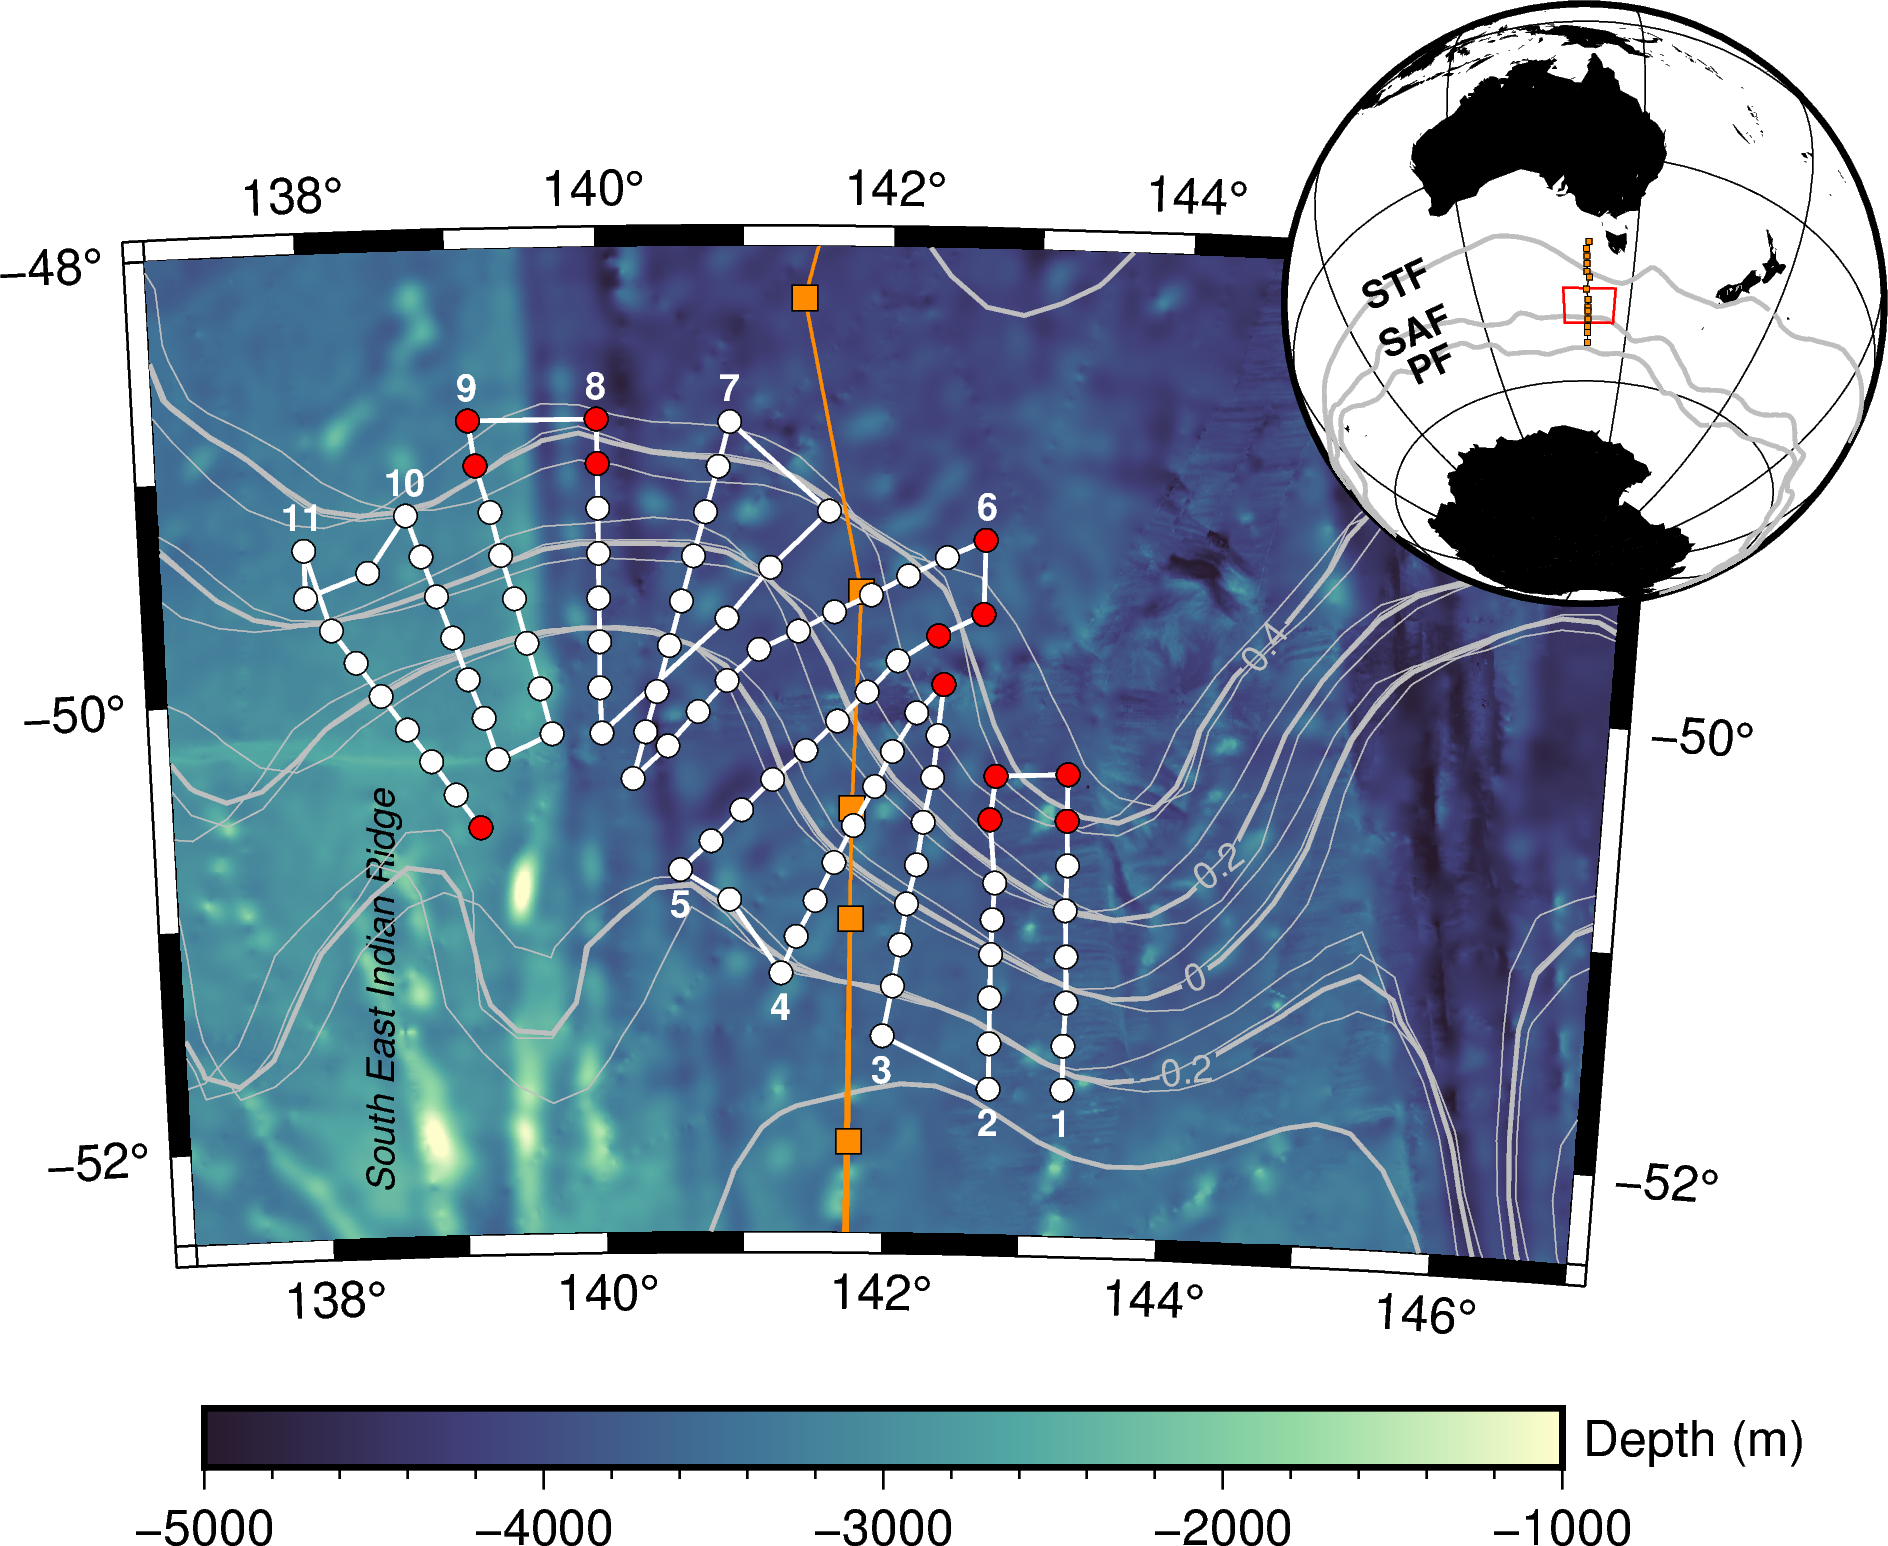

In [15]:
fs_small = 9
fs_large = 14
fontname = 'Helvetica'

fig = pygmt.Figure()
fig.coast(region=[137, 147, -52.4, -48], projection='B141/-51/-50/-49/5i', land='black', water='skyblue', frame=True)

# -DJRM+o0.6i/0+mc -I0.3 -Bx2+lTOPO -By+lkm
# plot bathymetry
fig.grdimage(dep, projection='B141/-51/-50/-49/5i', region=[137, 147, -52.4, -48], cmap='../cmaps/cmocean_deep.cpt')#, shading='+a120+nt1.5')
fig.colorbar(
    cmap="../cmaps/cmocean_deep.cpt",
    position="n0.04/-0.2+w11.5/0.5+h",  # plot using paper coordinates (x) at 1.2cm,4.75cm
    frame=["xaf", "y+lDepth\t(m)"], #-DJRM+o0.6i/0+e+mc
    scale=1,
)
# plot text
fig.text(text="South East Indian Ridge", x=138.4, y=-51.3, angle=90, font="%sp,%s-Oblique,black" %(fs_small, fontname))

# plot SSH contours
for i in range(weekmeanadt.shape[0]):
    fig.grdcontour(weekmeanadt[i], interval=0.2, annotation='-', limit=[-0.3, 0.5], pen='gray')
fig.grdcontour(adtvoy.mean('time'), interval=0.2, annotation=0.2, label_placement='l144/52S/145/48S', limit=[-0.4, 0.7], pen='1p,gray')

# plot AU9706 stations and shiptrack
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], pen='0.7p,darkorange')
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], style='s0.3c', color='darkorange', pen='black')

# plot SS9802 stations and shiptrack
fig.plot(x=ctd['lon'][2:,0], y=ctd['lat'][2:,0], pen='1p,white')
fig.plot(x=ctd['lon'][2:,0], y=ctd['lat'][2:,0], style='c0.2c', color='white', pen='black')
fig.plot(x=ctd['lon'][iodds,0], y=ctd['lat'][iodds,0], style='c0.2c', color='red', pen='black')

# plot transect numbers
for its in ts.keys():
    spacing = 0.15 if its > 5 else -0.15
    fig.text(text=str(its), x=ctd['lon'][ts[its],0], y=ctd['lat'][ts[its],0]+spacing, font="%sp,%s-Bold,white" %(fs_small, fontname))

# plot globe subplot and mean SSH contours of fronts from Orsi et al. 1995
fig.coast(region="g", projection="G141/-50.1/10000/0/0/0/0/0/2i", land="black", water='white', frame='afg', X='3.8i', Y='2.2i')
for front in fronts.keys():
    fig.plot(orsi[front][0], orsi[front][1], pen='1p,gray') #'0.75p,%s' %fronts[front]
#     fig.plot([140, 150], [-50, -52], text='5p'+'hello')

# plot SS9802 survey area in subplot
fig.plot([137.0, 147.0, 147.0, 137.0, 137.0], [-52.4, -52.4, -48.0, -48.0, -52.4], pen='0.5p,red')
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], pen='0.2p,black')
fig.plot(x=sr3['longitude'][istations], y=sr3['latitude'][istations], style='s0.07c', color='darkorange', pen='0.1p,black')

fig.text(x=105, y=-53, angle=25,text='PF',font='%sp,%s-Bold,black' %(fs_small,fontname))
fig.text(x=105, y=-48, angle=25,text='SAF',font='%sp,%s-Bold,black' %(fs_small,fontname))
fig.text(x=105, y=-41, angle=25,text='STF',font='%sp,%s-Bold,black' %(fs_small,fontname))

fig.show(dpi=300, width=1000)

In [16]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '01_overview-map' + extension), transparent=transparent)

## Meander evolution in time by ADT contours

In [17]:
fs_small = 25
fs_large = 30
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [21]:
adtvoy

<xarray.DataArray 'adt' (time: 17, latitude: 60, longitude: 100)>
array([[[-0.8748, -0.8687, ..., -1.0866, -1.0797],
        [-0.9115, -0.903 , ..., -0.9752, -0.9656],
        ...,
        [ 0.4853,  0.5054, ...,  0.4456,  0.4489],
        [ 0.4941,  0.5007, ...,  0.4473,  0.4534]],

       [[-0.8798, -0.873 , ..., -1.0834, -1.0758],
        [-0.9167, -0.9075, ..., -0.9708, -0.9588],
        ...,
        [ 0.488 ,  0.5075, ...,  0.4447,  0.4474],
        [ 0.4951,  0.5022, ...,  0.4473,  0.4534]],

       ...,

       [[-0.9135, -0.9327, ..., -1.0761, -1.057 ],
        [-0.9384, -0.9485, ..., -0.9734, -0.9398],
        ...,
        [ 0.518 ,  0.5303, ...,  0.4375,  0.4531],
        [ 0.5202,  0.5252, ...,  0.4599,  0.4685]],

       [[-0.923 , -0.9427, ..., -1.0794, -1.0597],
        [-0.9439, -0.9553, ..., -0.9788, -0.9451],
        ...,
        [ 0.5185,  0.5312, ...,  0.4392,  0.4542],
        [ 0.5215,  0.5265, ...,  0.4624,  0.4706]]])
Coordinates:
  * time       (time) datetime64[ns] 1998-03-12 1998-03-13 ... 1998-03-28
  * longitude  (longitude) float32 135.1 135.4 135.6 135.9 ... 159.4 159.6 159.9
  * latitude   (latitude) float32 -59.88 -59.62 -59.38 ... -45.62 -45.38 -45.12
Attributes:
    standard_name:  sea_surface_height_above_geoid
    long_name:      Absolute dynamic topography
    units:          m
    grid_mapping:   crs
    comment:        The absolute dynamic topography is the sea surface height...

Text(0, 0.5, '$ADT\\quad(\\mathrm{m})$')

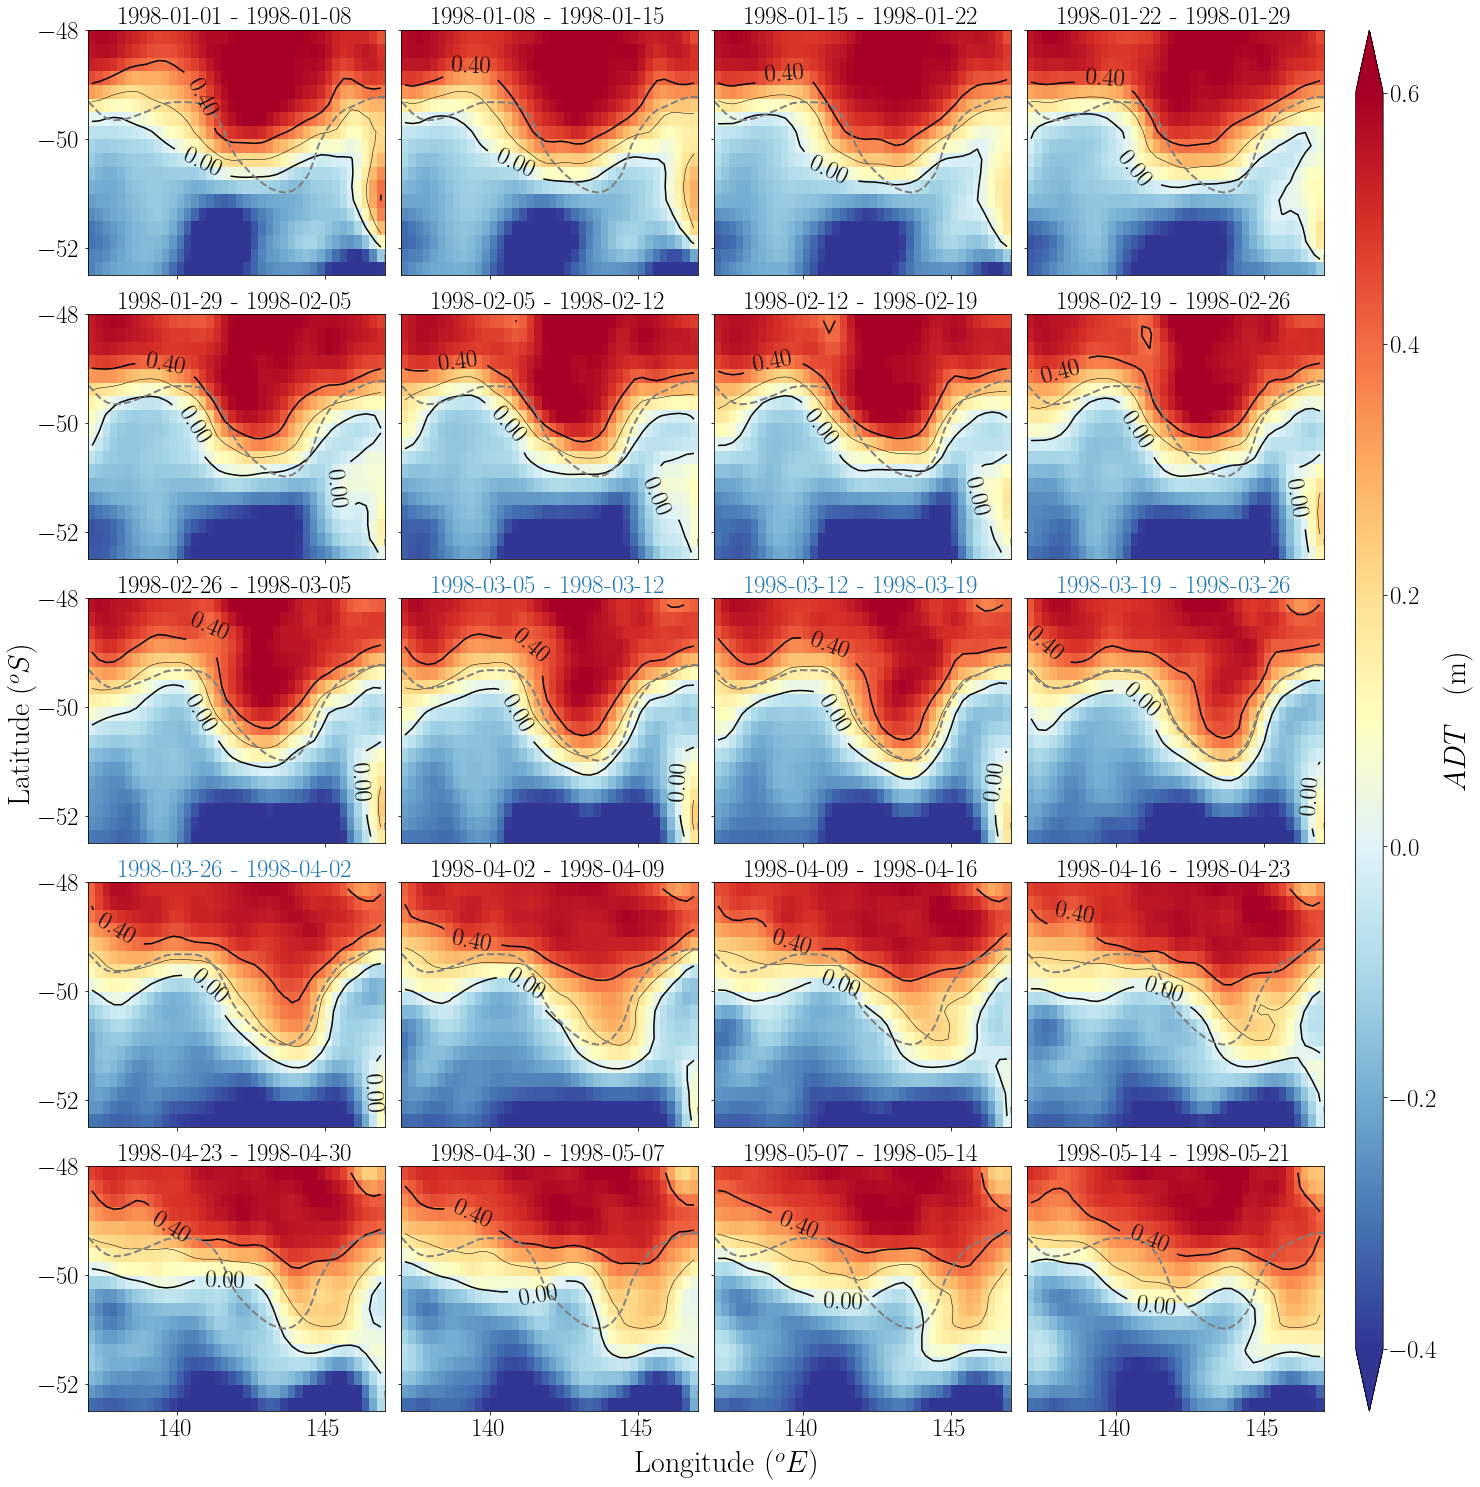

In [25]:
# adt_contours = np.linspace(-0.1, 0.4, 3)
adt_contours = [0, 0.2, 0.4]

nrows, ncols = 5, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20), 
                         sharex=True, sharey=True, constrained_layout=True)
for i, t in enumerate(adt_wkmean.time[0:20]):
    r, c = i // ncols, i % ncols    
    
    pcol = adt_wkmean.sel(time=t).plot.pcolormesh(
        ax=ax[r, c], vmin=-0.4, vmax=0.6, cmap=plt.cm.RdYlBu_r, add_colorbar=False)
#     pcol = (sst_wkmean - 273).sel(time=t).plot.pcolormesh(
#         ax=ax[r, c], vmin=4, vmax=11, cmap=cmo.cm.thermal, add_colorbar=False)
    cont = adt_wkmean.sel(time=t).plot.contour(
        ax=ax[r, c], levels=adt_contours, linestyles='solid', linewidths=0.5, colors='k')
    
    cont_voy = adtvoy.mean('time').plot.contour(
        ax=ax[r, c], levels=[0.2], linestyles='dashed', linewidths=2, colors='gray')
    
    for ib, b in enumerate(adt_contours):
        if b in adt_contours[0::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[r, c].clabel(cont, adt_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')
    
    ax[r, c].set_ylabel('')
    ax[r, c].set_xlabel('')
    ts = pd.to_datetime(str(adt_wkmean.time[i+1].data))
    t_beg = pd.to_datetime(str(t.data)).strftime('%Y-%m-%d')
    t_end = pd.to_datetime(str(adt_wkmean.time[i+1].data)).strftime('%Y-%m-%d')
    title_color = 'tab:blue' if (t.values in adtvoy.time.values) | (adt_wkmean.time[i+1].values in 
                                                                    adtvoy.time.values) else 'k'

    ax[r, c].set_title('%s - %s' %(t_beg, t_end), fontsize=fs_small, color=title_color)

        
fig.text(0.48, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel(r'$ADT\quad(\mathrm{m})$', fontsize=fs_large)
# cbar.ax.set_ylabel(r'$SST\quad(^\circ C)$', fontsize=fs_large)



In [26]:
savefig=True

In [27]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '02_meander-evolution' + extension), transparent=transparent)